In [ ]:
import os

In [ ]:
!pip install binarytree
!pip install pandas

In [ ]:
from binarytree import tree, Node
from math import floor

In [ ]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='2'

**LSH**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

def generate_data(N, D):
    return np.random.randn(N, D)

def add_bias(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

def random_projections(D, P):
    return np.random.randn(D + 1, P)

def compute_hashes(X, R):
    return np.sign(X @ R)

def build_hash_table(hashes):
    table = {}
    for idx, h in enumerate(hashes):
        key = tuple(h)
        if key not in table:
            table[key] = []
        table[key].append(idx)
    return table

def query(table, query_hash):
    key = tuple(query_hash)
    return table.get(key, [])

# Experiment parameters
N_values = np.arange(500, 10300, 200)  # Vary N from 500 to 10300 in steps of 800
D_values = [1, 2, 3, 4, 5, 9, 12, 50]  # Specific values of D
P = 5  # Fixed number of projections
K = 5  # Fixed number of nearest neighbors

# Initialize dictionaries to store results
results_N = {'training_time': [], 'testing_time': [], 'memory_usage': []}
results_D = {'training_time': [], 'testing_time': [], 'memory_usage': []}

# Varying N
for N in N_values:
    X = generate_data(N, D=2)  # Use a fixed dimension, let's say D = 2
    X_aug = add_bias(X)
    R = random_projections(2, P)  # We use 2 because we're keeping D fixed here

    # Build time measurement
    start_time = time.time()
    hashes = compute_hashes(X_aug, R)
    hash_table = build_hash_table(hashes)
    build_time = time.time() - start_time

    #Testing time measurement
    query_point = add_bias(generate_data(1, 2))
    query_hash = compute_hashes(query_point, R)
    start_time = time.time()
    _ = query(hash_table, query_hash[0])
    testing_time = time.time() - start_time

    # Memory usage measurement
    memory_usage = sys.getsizeof(hash_table)

    # Collect results
    results_N['training_time'].append(build_time)
    results_N['testing_time'].append(testing_time)
    results_N['memory_usage'].append(memory_usage / (1024 ** 2))  # Convert bytes to MB

# Varying D
for D in D_values:
    X = generate_data(1000, D)  # Use a fixed number of points, N = 1000
    X_aug = add_bias(X)
    R = random_projections(D, P)

    # Build time measurement
    start_time = time.time()
    hashes = compute_hashes(X_aug, R)
    hash_table = build_hash_table(hashes)
    build_time = time.time() - start_time

    # Testing time measurement
    query_point = add_bias(generate_data(1, D))
    query_hash = compute_hashes(query_point, R)
    start_time = time.time()
    _ = query(hash_table, query_hash[0])
    testing_time = time.time() - start_time

    # Memory usage measurement
    memory_usage = sys.getsizeof(hash_table)

    # Collect results
    results_D['training_time'].append(build_time)
    results_D['testing_time'].append(testing_time)
    results_D['memory_usage'].append(memory_usage / (1024 ** 2))  # Convert bytes to MB




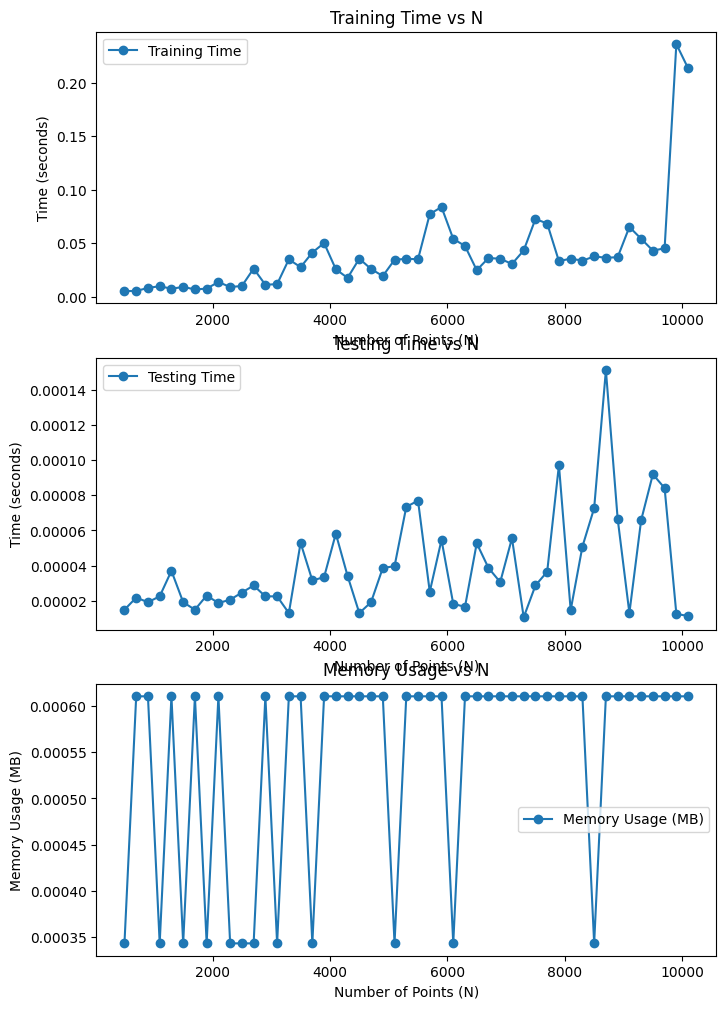

In [ ]:
# Plotting results for N
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
ax[0].plot(N_values, results_N['training_time'], marker='o', label='Training Time')
ax[0].set_xlabel('Number of Points (N)')
ax[0].set_ylabel('Time (seconds)')
ax[0].set_title('Training Time vs N')
ax[0].legend()

ax[1].plot(N_values, results_N['testing_time'], marker='o', label='Testing Time')
ax[1].set_xlabel('Number of Points (N)')
ax[1].set_ylabel('Time (seconds)')
ax[1].set_title('Testing Time vs N')
ax[1].legend()

ax[2].plot(N_values, results_N['memory_usage'], marker='o', label='Memory Usage (MB)')
ax[2].set_xlabel('Number of Points (N)')
ax[2].set_ylabel('Memory Usage (MB)')
ax[2].set_title('Memory Usage vs N')
ax[2].legend()

1. Training time vs N: As the number of Data points increase the training time increases since time for computing and buliding the hashes increases.
2. Testing time vs N: The testing time remians relatively constant but ovarall follows an increasing trend. There is no direct reationship with N here.
3. Memory usage vs N: Memory usage increases with N as more resources are required for storing the computed hashes.

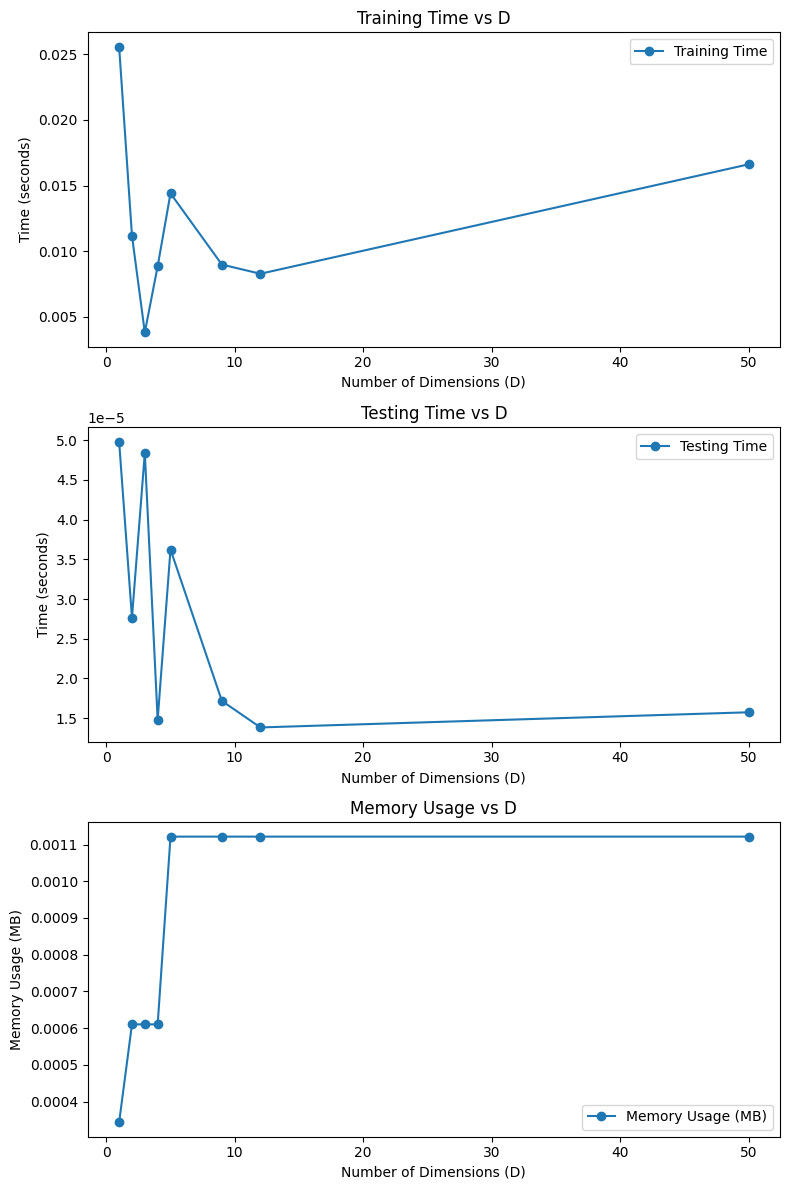

In [ ]:
# Plotting results for D
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
ax[0].plot(D_values, results_D['training_time'], marker='o', label='Training Time')
ax[0].set_xlabel('Number of Dimensions (D)')
ax[0].set_ylabel('Time (seconds)')
ax[0].set_title('Training Time vs D')
ax[0].legend()

ax[1].plot(D_values, results_D['testing_time'], marker='o', label='Testing Time')
ax[1].set_xlabel('Number of Dimensions (D)')
ax[1].set_ylabel('Time (seconds)')
ax[1].set_title('Testing Time vs D')
ax[1].legend()

ax[2].plot(D_values, results_D['memory_usage'], marker='o', label='Memory Usage (MB)')
ax[2].set_xlabel('Number of Dimensions (D)')
ax[2].set_ylabel('Memory Usage (MB)')
ax[2].set_title('Memory Usage vs D')
ax[2].legend()

plt.tight_layout()
plt.show()

1. Training time vs D: As the number of Data points increase the training time but not in a linear manner.
2. Testing time vs D: The testing time increases drastically as D increases
3. Memory usage vs D: Memory usage increases with D as more resources are required for storing the computed hashes but the effect is less pronounced as compared to N.

**KNN**

In [ ]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='2'

In [ ]:
import numpy as np
from collections import Counter

def euclidean_distance(x1, x2):
    distance = np.sqrt(np.sum((x1-x2)**2))
    return distance

class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return predictions

    def _predict(self, x):
        # compute the distance
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]

        # get the closest k
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # majority voye
        most_common = Counter(k_nearest_labels).most_common()
        return most_common[0][0]

**KNN Training by varying $N$ and $D$ and hence testing time and memory comparison for finding $K$ nearest neighbours.**

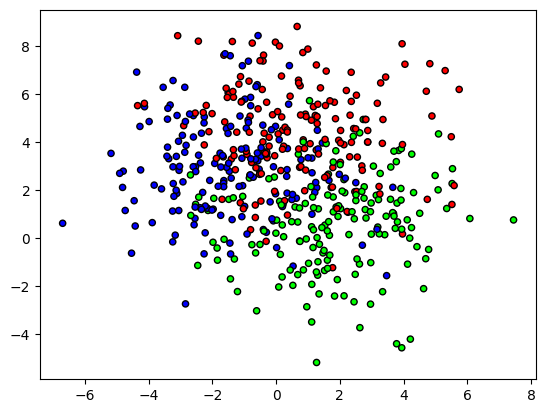

[1, 0, 1, 1, 1, 2, 0, 0, 0, 2, 0, 0, 2, 2, 1, 0, 0, 2, 2, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2, 1, 0, 2, 0, 2, 2, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 2, 1, 0, 2, 2, 2, 1, 0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 0, 2, 2, 0, 1, 0, 2, 2, 2, 0, 2, 2, 1, 0, 1, 1, 1, 1, 0, 1, 2, 0, 1, 1, 2, 2, 0, 0, 1, 0, 2, 0]
Accuracy: 0.65


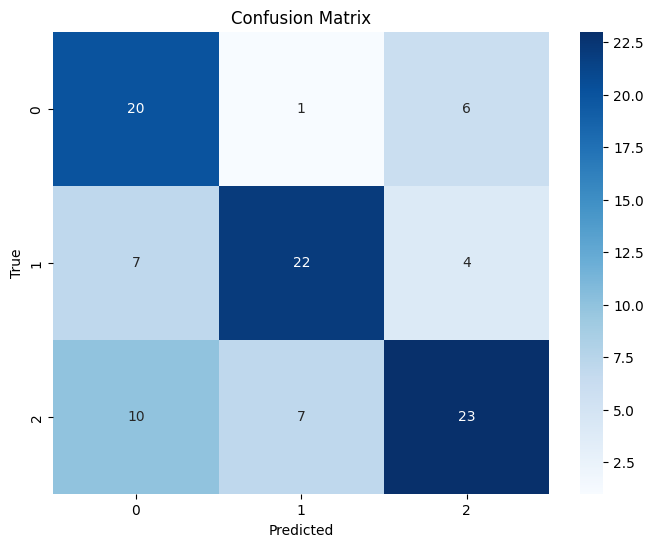

              precision    recall  f1-score   support

           0       0.54      0.74      0.62        27
           1       0.73      0.67      0.70        33
           2       0.70      0.57      0.63        40

    accuracy                           0.65       100
   macro avg       0.66      0.66      0.65       100
weighted avg       0.67      0.65      0.65       100



In [ ]:
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_blobs
import time
import psutil  # for memory usage
from sklearn.model_selection import train_test_split  # Add import statement for train_test_split


#X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=0, cluster_std=2)

# Generating a random dataset with a pattern
X_pattern, y_pattern = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=0)

# Plotting the random dataset with pattern
cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.figure()
plt.scatter(X_pattern[:, 0], X_pattern[:, 1], c=y_pattern, cmap=cmap, edgecolor='k', s=20)
plt.show()

# Splitting the random dataset into training and testing sets
X_train_pattern, X_test_pattern, y_train_pattern, y_test_pattern = train_test_split(X_pattern, y_pattern, test_size=0.2, random_state=1234)

# KNN implementation
clf_pattern = KNN(k=5)
clf_pattern.fit(X_train_pattern, y_train_pattern)
predictions_pattern = clf_pattern.predict(X_test_pattern)

print(predictions_pattern)

acc_pattern = np.sum(predictions_pattern == y_test_pattern) / len(y_test_pattern)
print("Accuracy:", acc_pattern)

#Confusion matrix
conf_matrix_pattern = confusion_matrix(y_test_pattern, predictions_pattern)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_pattern, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(y_pattern), yticklabels=np.unique(y_pattern))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test_pattern, predictions_pattern))


In [ ]:
point_prediction = clf_pattern.predict([[-2.5, 5]])

# Get the color corresponding to the predicted class
predicted_class_color = cmap(point_prediction)

print("Predicted class for the point:", point_prediction)

Predicted class for the point: [2]


Predicted class for the point: [2]


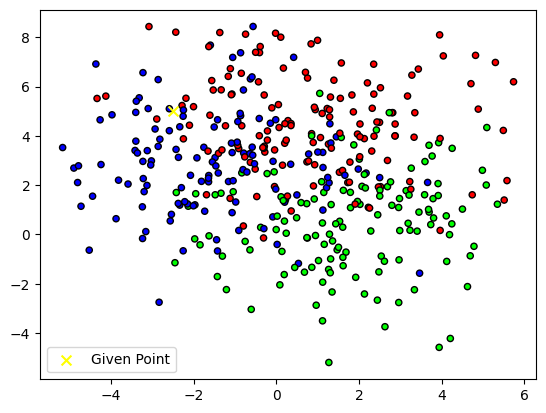

In [ ]:
point_prediction = clf_pattern.predict([[-2.5, 5]])

# Get the color corresponding to the predicted class
predicted_class_color = cmap(point_prediction)

print("Predicted class for the point:", point_prediction)

# Plotting the training data with the given point
plt.figure()
plt.scatter(X_train_pattern[:, 0], X_train_pattern[:, 1], c=y_train_pattern, cmap=cmap, edgecolor='k', s=20)
plt.scatter(-2.5, 5, color='yellow', marker='x',s=50, label='Given Point')  # Plotting given point
plt.legend()
plt.show()


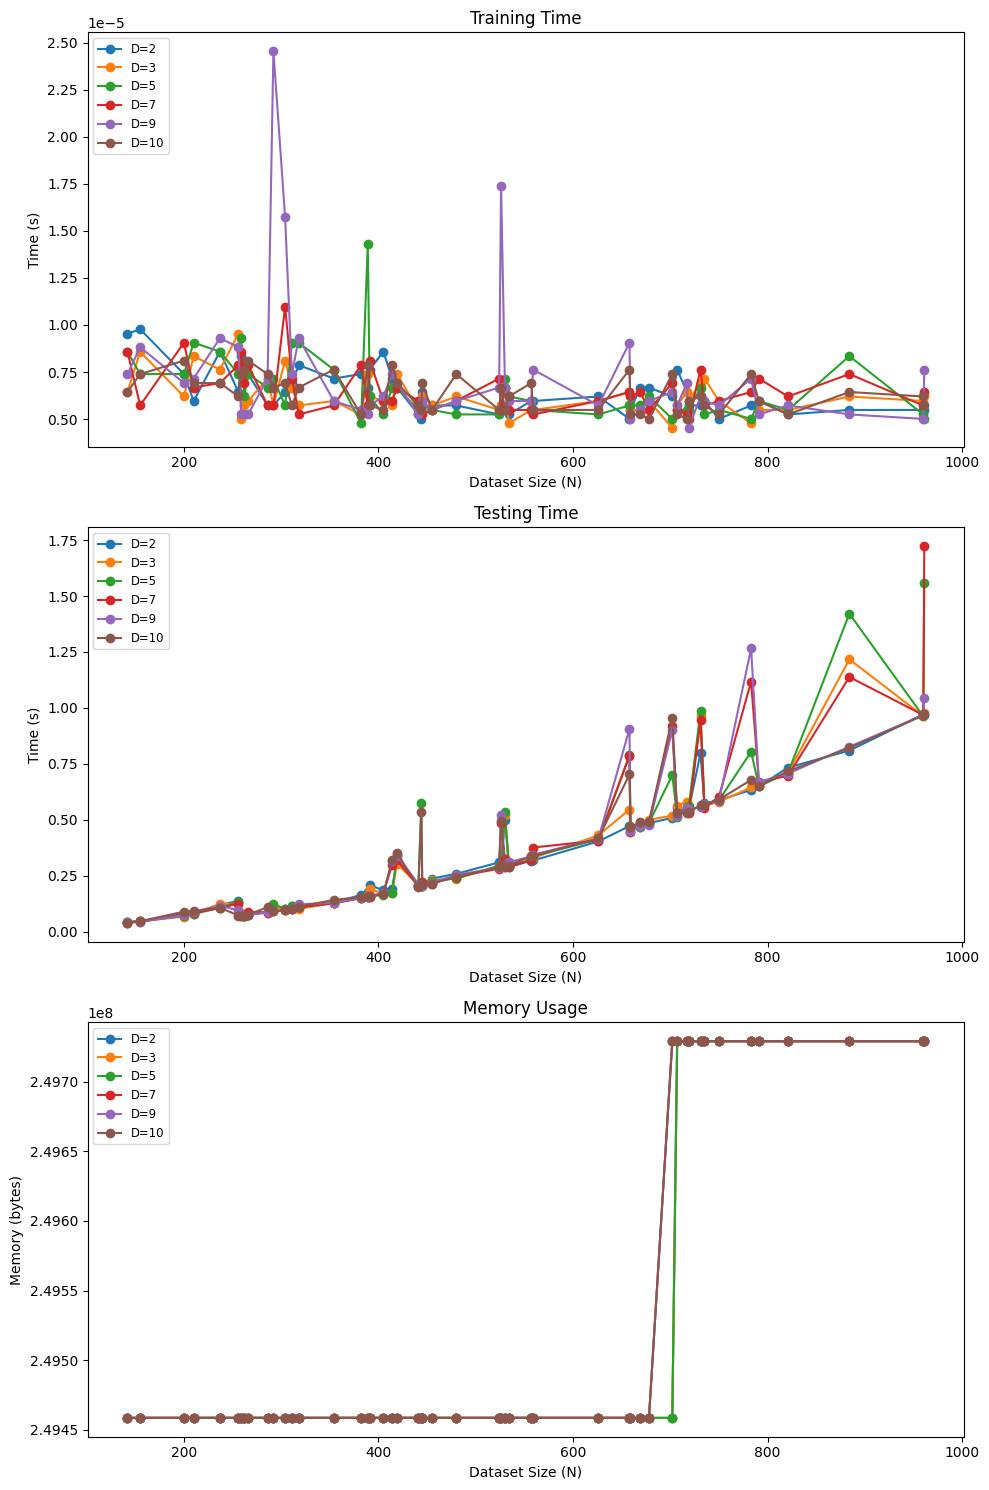

In [ ]:
import time
import psutil  # for memory usage
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import numpy as np

# Varying parameters
N_values = np.sort(np.random.randint(low=100, high=1000, size=50))
D_values = [2, 3, 5, 7, 9, 10]       # Number of dimensions
K = 5                         # Number of nearest neighbors

training_times = np.zeros((len(N_values), len(D_values)))
testing_times = np.zeros((len(N_values), len(D_values)))
memory_usages = np.zeros((len(N_values), len(D_values)))

for i, N in enumerate(N_values):
    for j, D in enumerate(D_values):
        # Generate random dataset with pattern
        X_pattern, y_pattern = make_blobs(n_samples=N, centers=3, n_features=D, cluster_std=2, random_state=0)

        # Split dataset into training and testing sets
        X_train_pattern, X_test_pattern, y_train_pattern, y_test_pattern = train_test_split(X_pattern, y_pattern, test_size=0.2, random_state=1234)

        # Measure training time
        start_time = time.time()
        clf_pattern = KNN(k=K)
        clf_pattern.fit(X_train_pattern, y_train_pattern)
        training_times[i, j] = time.time() - start_time

        # Measure testing time
        start_time = time.time()
        predictions_pattern = clf_pattern.predict(X_test_pattern)
        testing_times[i, j] = time.time() - start_time

        # Measure memory usage
        process = psutil.Process()
        memory_usages[i, j] = process.memory_info().rss  # in bytes

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot training time
for j, D in enumerate(D_values):
    axs[0].plot(N_values, training_times[:, j], marker='o', label=f'D={D}')
axs[0].set_title('Training Time')
axs[0].set_xlabel('Dataset Size (N)')
axs[0].set_ylabel('Time (s)')
axs[0].legend(fontsize='small', loc='upper left')

# Plot testing time
for j, D in enumerate(D_values):
    axs[1].plot(N_values, testing_times[:, j], marker='o', label=f'D={D}')
axs[1].set_title('Testing Time')
axs[1].set_xlabel('Dataset Size (N)')
axs[1].set_ylabel('Time (s)')
axs[1].legend(fontsize='small', loc='upper left')

# Plot memory usage
for j, D in enumerate(D_values):
    axs[2].plot(N_values, memory_usages[:, j], marker='o', label=f'D={D}')
axs[2].set_title('Memory Usage')
axs[2].set_xlabel('Dataset Size (N)')
axs[2].set_ylabel('Memory (bytes)')
axs[2].legend(fontsize='small', loc='upper left')

plt.tight_layout()
plt.show()


1. Training time vs N,D: As N increases the training time remains more or less contant but with respect to D values increasing the training time achives peakes locally.
2. Testing time vs N,D: The testing time increases linearly with respect to increasing N and D.
3. Memory usage vs N,D: Memory usage remains constantly low till the threshold value of 700 and the increases to remain stable there.

**KD-Tree**

In [ ]:
import numpy as np

def distance(point1, point2):
    return np.linalg.norm(point1 - point2)

In [ ]:
from math import floor
import numpy as np
import pandas as pd

class MyNode:
    def __init__(self, _id, data, axis, idx):
        self._id = _id
        self.data = data
        self.axis = axis
        self.idx = idx
        self.left = None
        self.right = None

class KD_Tree:
    def __init__(self, data):
        self.data = data
        self.tree = None

    def _build(self, points, depth):
        k = len(points.columns)
        _axis = depth % k
        _column = points.columns[_axis]

        if len(points) == 0:
            return None

        objects_list = points.sort_values(by=[_column], ascending=True)

        if len(objects_list) % 2 == 0:
            median_idx = int((len(objects_list) / 2))
        else:
            median_idx = floor((len(objects_list) / 2))

        node = MyNode(_id=round(objects_list.iloc[median_idx][_column], 3),
                      data=objects_list.iloc[median_idx],
                      axis=_column,
                      idx=median_idx)

        if len(objects_list) <= 40:
            return node  # Stop further branching if number of data points is 40 or fewer

        node.left = self._build(objects_list.iloc[0:median_idx], depth + 1)
        node.right = self._build(objects_list.iloc[median_idx + 1:], depth + 1)

        return node

    def build(self):
        self.tree = self._build(self.data, depth=0)

    def _nearest(self, query, node, best_node, best_distance):
        if not node:
            return best_node, best_distance

        d = distance(query.values[0], node.data.values)

        if d < best_distance:
            best_node = node
            best_distance = d
            print("best Node: {}".format(best_node.data.values))

        if query[node.axis].values[0] < node.data[node.axis]:
            good_side = node.left
            bad_side = node.right
        else:
            bad_side = node.left
            good_side = node.right

        best_node, best_distance = self._nearest(query, good_side, best_node, best_distance)

        if abs(node.data[node.axis] - query[node.axis].values[0]) < best_distance:
            best_node, best_distance = self._nearest(query, bad_side, best_node, best_distance)

        return best_node, best_distance

    def get_nn(self, query):
        return self._nearest(query, self.tree, None, np.inf)

**KD-tree Training by varying $N$ and $D$ and hence testing time and memory comparison for finding $K$ nearest neighbours.**

In [ ]:
def generate_dataset(N, D):
    # Generate random values
    random_values = np.random.rand(N, D)
    # Round the values to two decimal places
    rounded_values = np.round(random_values, 2)
    # Create DataFrame from rounded values
    return pd.DataFrame(rounded_values, columns=[f"X{i}" for i in range(D)])

In [ ]:
def measure_time_and_memory(N_values, D_values, KD_tree, k):
    training_times = []
    testing_times = []
    memory_usage = []

    for N in N_values:
        for D in D_values:
            # Generate random dataset
            dataset = generate_dataset(N, D)
            query_point = pd.DataFrame(np.random.rand(1, D), columns=[f"X{i}" for i in range(D)])

            # Build KD Tree
            KD = KD_tree(dataset)
            start_time = time.time()
            KD.build()
            end_time = time.time()
            training_time = end_time - start_time

            # Measure testing time
            start_time = time.time()
            KD.get_nn(query_point)
            end_time = time.time()
            testing_time = end_time - start_time

            # Measure memory usage
            process = psutil.Process()
            process_memory = process.memory_info().rss
            memory_usage.append(process_memory)

            # Append to lists
            training_times.append(training_time)
            testing_times.append(testing_time)

    return training_times, testing_times, memory_usage

In [ ]:
import time
import psutil  # For memory usage
import matplotlib.pyplot as plt

best Node: [0.53 0.25]
best Node: [0.11 0.45]
best Node: [0.3  0.55]
best Node: [0.3 0.7]
best Node: [0.52 0.56 0.56]
best Node: [0.53 0.47 0.68]
best Node: [0.82 0.45 0.57]
best Node: [0.78 0.2  0.3 ]
best Node: [0.48 0.06 0.02 0.02 0.36]
best Node: [0.64 0.46 0.03 0.79 0.52]
best Node: [0.85 0.4  0.47 0.42 0.03]
best Node: [0.86 0.56 0.85 0.5  0.37]
best Node: [0.52 0.79 0.46 0.32 0.27 0.73 0.26]
best Node: [0.51 0.49 0.16 0.17 0.41 0.1  0.5 ]
best Node: [0.18 0.49 0.9  0.38 0.61 0.1  0.99]
best Node: [0.83 0.06 0.56 0.3  0.41 0.23 0.52]
best Node: [0.49 0.26 0.96 0.51 0.52 0.79 0.35 0.38 0.7 ]
best Node: [0.01 0.51 0.35 0.67 0.77 0.63 0.55 0.64 0.95]
best Node: [0.55 0.62 0.38 0.76 0.51 0.02 0.37 0.48 0.66]
best Node: [0.49 0.8  0.18 0.61 0.3  0.44 0.78 0.55 0.77 0.15]
best Node: [0.47 0.91 0.47 0.85 0.7  0.02 0.75 0.43 0.74 0.18]
best Node: [0.5  0.54]
best Node: [0.25 0.42]
best Node: [0.37 0.24]
best Node: [0.36 0.12]
best Node: [0.54 0.96 0.94]
best Node: [0.48 0.44 0.57]
best N

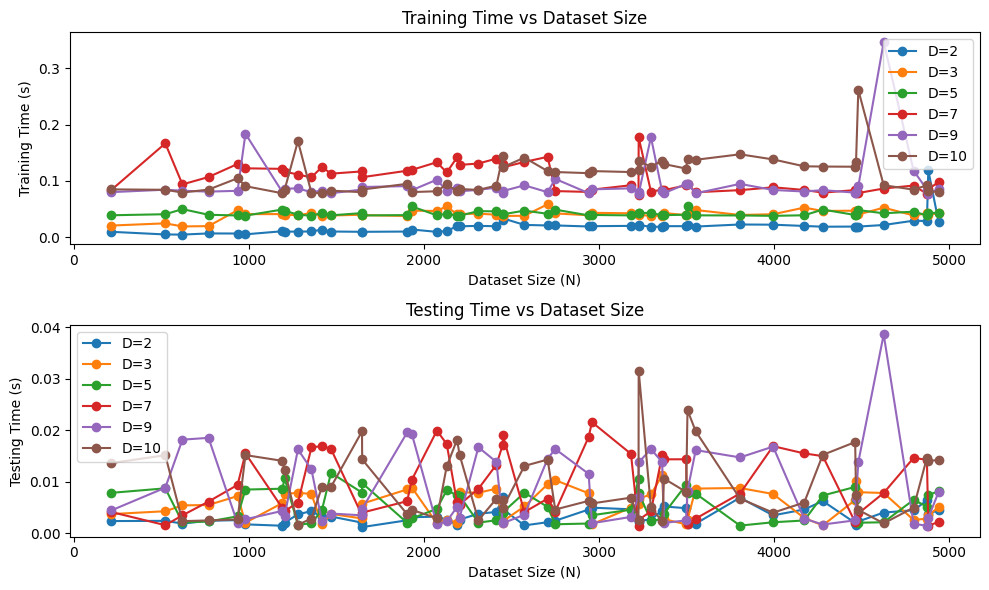

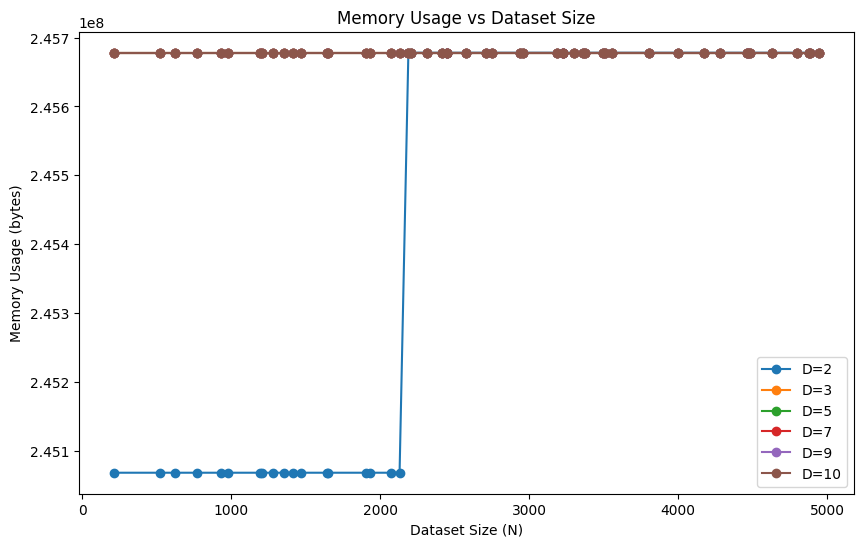

In [ ]:
# Define parameters
#N_values = np.random.randint(low=100, high=1000, size=50)  # Varying dataset sizes
N_values = np.sort(np.random.randint(low=100, high=5000, size=50))
D_values = [2, 3, 5, 7, 9, 10]  # Varying number of dimensions
k = 5  # Number of nearest neighbors

# Measure time and memory
training_times, testing_times, memory_usage = measure_time_and_memory(N_values, D_values, KD_Tree, k)

# Plot results
plt.figure(figsize=(10, 6))

# Plot training time
plt.subplot(2, 1, 1)
for i, D in enumerate(D_values):
    plt.plot(N_values, training_times[i * len(N_values):(i + 1) * len(N_values)], marker='o', label=f"D={D}")
plt.title('Training Time vs Dataset Size')
plt.xlabel('Dataset Size (N)')
plt.ylabel('Training Time (s)')
plt.legend()
# Plot testing time
plt.subplot(2, 1, 2)
for i, D in enumerate(D_values):
    plt.plot(N_values, testing_times[i * len(N_values):(i + 1) * len(N_values)], marker='o', label=f"D={D}")
plt.title('Testing Time vs Dataset Size')
plt.xlabel('Dataset Size (N)')
plt.ylabel('Testing Time (s)')
plt.legend()

plt.tight_layout()
plt.show()

# Plot memory usage
plt.figure(figsize=(10, 6))
for i, D in enumerate(D_values):
    plt.plot(N_values, memory_usage[i * len(N_values):(i + 1) * len(N_values)], marker='o', label=f"D={D}")
plt.title('Memory Usage vs Dataset Size')
plt.xlabel('Dataset Size (N)')
plt.ylabel('Memory Usage (bytes)')
plt.legend()
plt.show()

1. Training time vs N,D: As N increases the training time remains more or less contant but with respect to D values increasing the training time increases and achives local peaks.
2. Testing time vs N,D: The testing time shows fluctuating trends with N and D increasing. The Fluctuations increase as D increases.
3. Memory usage vs N,D: Memory usage remains constantly for smaller N and D values and then attains an increase with an increase in N. For larger D values the value of N doesnt matter. The memory usage is always high in such cases.